# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
#from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_ind, ttest_rel
from collections import namedtuple
from recordtype import recordtype

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)
#numpy.seterr(divide='ignore', invalid='ignore')

In [2]:
SEED = 0
JOBS = 10

In [203]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [131]:
transaction = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')
identity = df.read_csv('./data/train_identity.csv', header=0, ).set_index('TransactionID')

In [132]:
transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [134]:
transaction.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [135]:
identity.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 40 entries, id_01 to DeviceInfo
dtypes: object(17), float64(23)

In [7]:
transaction['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [56]:
transaction.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [129]:
identity.isnull().sum().compute()

id_01              0
id_02           3361
id_03          77909
id_04          77909
id_05           7368
id_06           7368
id_07         139078
id_08         139078
id_09          69307
id_10          69307
id_11           3255
id_12              0
id_13          16913
id_14          64189
id_15           3248
id_16          14893
id_17           4864
id_18          99120
id_19           4915
id_20           4972
id_21         139074
id_22         139064
id_23         139064
id_24         139486
id_25         139101
id_26         139070
id_27         139064
id_28           3255
id_29           3255
id_30          66668
id_31           3951
id_32          66647
id_33          70944
id_34          66428
id_35           3248
id_36           3248
id_37           3248
id_38           3248
DeviceType      3423
DeviceInfo     25567
dtype: int64

In [136]:
data = transaction.join(identity, how='left')

In [137]:
sample_pos = data[data['isFraud']==1]
sample_neg = data[data['isFraud']==0].sample(frac=0.05, random_state=SEED)

In [138]:
sample = df.concat([sample_pos, sample_neg]).compute()

<AxesSubplot:xlabel='dist2'>

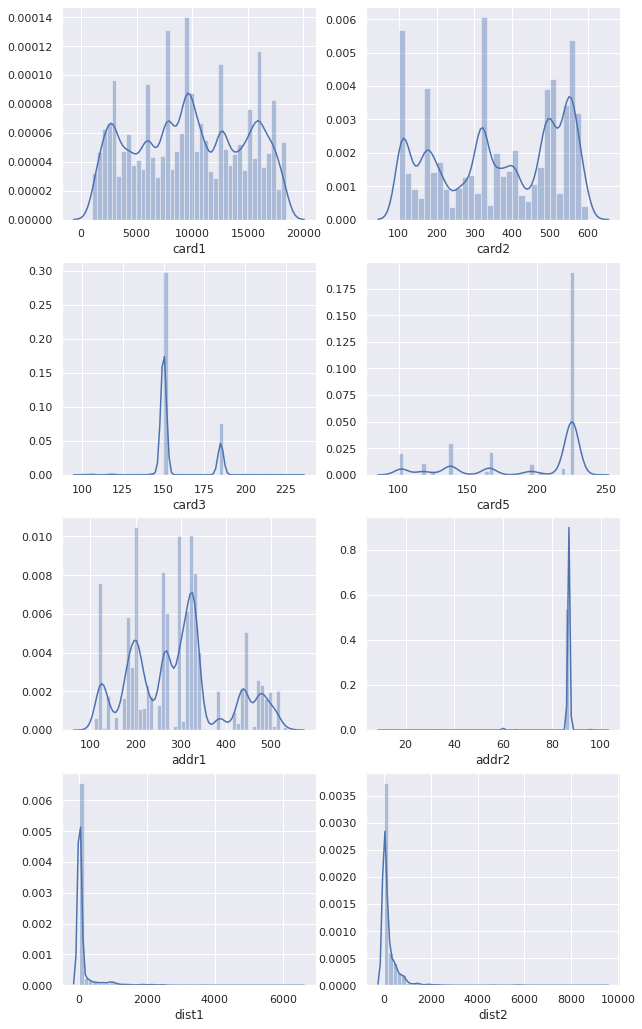

In [139]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,18))
sns.distplot(sample['card1'], ax=ax[0,0])
sns.distplot(sample['card2'], ax=ax[0,1])
sns.distplot(sample['card3'], ax=ax[1,0])
sns.distplot(sample['card5'], ax=ax[1,1])
sns.distplot(sample['addr1'], ax=ax[2,0])
sns.distplot(sample['addr2'], ax=ax[2,1])
sns.distplot(sample['dist1'], ax=ax[3,0])
sns.distplot(sample['dist2'], ax=ax[3,1])

In [140]:
sample.to_csv('./data/sample.csv', header=True, index=True)

In [3]:
types = {'TransactionAmt': 'float32',
         'ProductCD': 'category',
         'addr1': 'float32',
         'addr2': 'category',
         'dist1': 'float32',
         'dist2': 'float32',
         'P_emaildomain': 'category',
         'R_emaildomain': 'category',
         'card1': 'float32',
         'card2': 'float32',
         'card3': 'category',
         'card4': 'category',
         'card5': 'category',
         'card6': 'category'}

types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({f'V{i}': 'float32' for i in range(1, 340)})
types.update({(f'id_0{i}' if i<10 else f'id_{i}'): 'float32' for i in range(1, 12)})
types.update({f'id_{i}': 'category' for i in range(12, 39)})
types.update({'DeviceType': 'category', 'DeviceInfo': 'category'})

categorical = [k for k, v in types.items() if v == 'category']
numerical = [k for k, v in types.items() if v != 'category']

In [4]:
data = pandas.read_csv('./data/sample.csv', header=0, dtype=types).set_index('TransactionID')

In [5]:
data.drop(columns=['TransactionDT'], inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3564207
Columns: 432 entries, isFraud to DeviceInfo
dtypes: category(46), float32(385), int64(1)
memory usage: 75.3 MB


In [8]:
y = data['isFraud']
X = data.drop(columns=['isFraud'])
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,NaN,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN


In [9]:
y.value_counts()

0    28493
1    20663
Name: isFraud, dtype: int64

In [10]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [11]:
X[numerical] = mean_imp.fit_transform(X[numerical])
X[categorical] = mode_imp.fit_transform(X[categorical])

In [12]:
X.isnull().sum()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
                 ..
id_36             0
id_37             0
id_38             0
DeviceType        0
DeviceInfo        0
Length: 431, dtype: int64

## Visualization

In [13]:
X_ = X.copy()

In [14]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)

In [15]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,4,18268.0,583.0,29,3,64,1,251.000000,30,...,38,2,46,2,0,0,1,0,0,660
2987240,37.098000,0,13413.0,103.0,48,3,20,1,291.504517,30,...,20,2,46,2,0,0,1,1,1,385
2987243,37.098000,0,13413.0,103.0,48,3,20,1,291.504517,30,...,20,2,46,2,0,0,1,1,1,385
2987245,37.098000,0,13413.0,103.0,48,3,20,1,291.504517,30,...,20,2,46,2,0,0,1,1,1,385
2987288,155.520996,0,16578.0,545.0,48,3,64,1,291.504517,30,...,37,2,46,2,0,0,0,0,1,660


In [16]:
X_ = MinMaxScaler().fit_transform(X_)

In [17]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

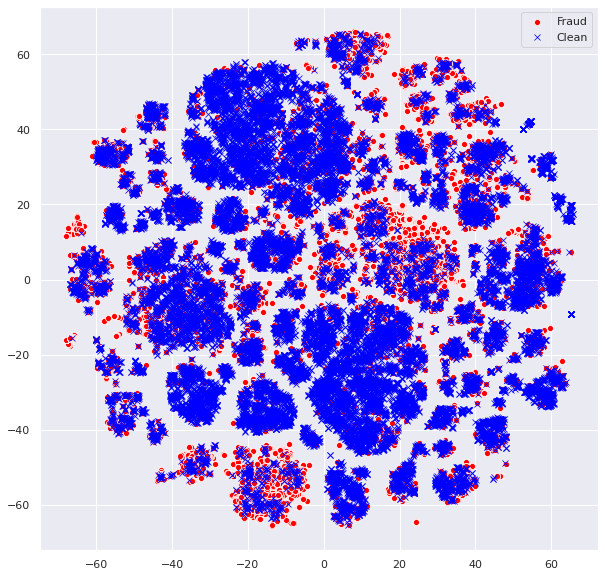

In [18]:
y_ = y.to_numpy()
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[y_==1, 0], y=X_[y_==1, 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[y_==0, 0], y=X_[y_==0, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [19]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

In [26]:
X_ = X.copy()

In [27]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)

In [28]:
variance_filter = VarianceThreshold(threshold=0)
variance_filter.fit(X_)

VarianceThreshold(threshold=0)

In [29]:
constant_columns = [column for column in X_.columns if column not in X_.columns[variance_filter.get_support()]]
constant_columns

['M1', 'V305', 'id_27']

In [30]:
tester = Hypot()

mapping = {k: 'cont' for k in numerical}
mapping.update({k: 'cat' for k in categorical})

del mapping['M1']
del mapping['V305']
del mapping['id_27']


In [31]:
p = tester.test(data=X_, mapping=mapping)

In [32]:
p

,TransactionAmt,addr1,dist1,dist2,card1,card2,C1,C2,C3,C4,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionAmt,1.00000,0.00131,0.00004,0.65583,0.60845,0.00000,0.00000,0.00000,0.16504,0.00014,...,0.00000,0.00000,0.00134,0.00000,0.92492,0.00000,0.00000,0.00000,0.00000,0.0
addr1,0.00131,1.00000,0.41671,0.82297,0.00000,0.00000,0.69752,0.80166,0.60050,0.62084,...,0.01363,0.00000,0.00000,0.00000,0.00000,0.60375,0.00000,0.01033,0.00106,1.0
dist1,0.00004,0.41671,1.00000,1.00000,0.00231,0.00003,0.65669,0.76031,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN
dist2,0.65583,0.82297,1.00000,1.00000,0.94389,0.17448,0.63851,0.18238,0.18496,0.52964,...,0.00000,0.99336,0.00000,0.69277,0.06558,0.00000,0.12137,0.31000,0.17496,0.0
card1,0.60845,0.00000,0.00231,0.94389,1.00000,0.30175,0.31173,0.51062,0.18072,0.10849,...,0.00000,0.01617,0.00004,0.08325,0.00002,0.08255,0.00202,0.00000,0.00002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_36,0.00000,0.60375,1.00000,0.00000,0.08255,0.00001,0.51355,0.57731,0.00000,0.28916,...,0.00000,0.31492,0.00000,0.64068,0.00000,1.00000,0.77175,0.00000,0.00000,0.0
id_37,0.00000,0.00000,1.00000,0.12137,0.00202,0.00000,0.00000,0.00000,0.18254,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.77175,1.00000,0.00000,0.00000,0.0
id_38,0.00000,0.01033,1.00000,0.31000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.0
DeviceType,0.00000,0.00106,1.00000,0.17496,0.00002,0.00006,0.00000,0.00000,0.00595,0.00000,...,0.00000,0.00000,0.00004,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.0


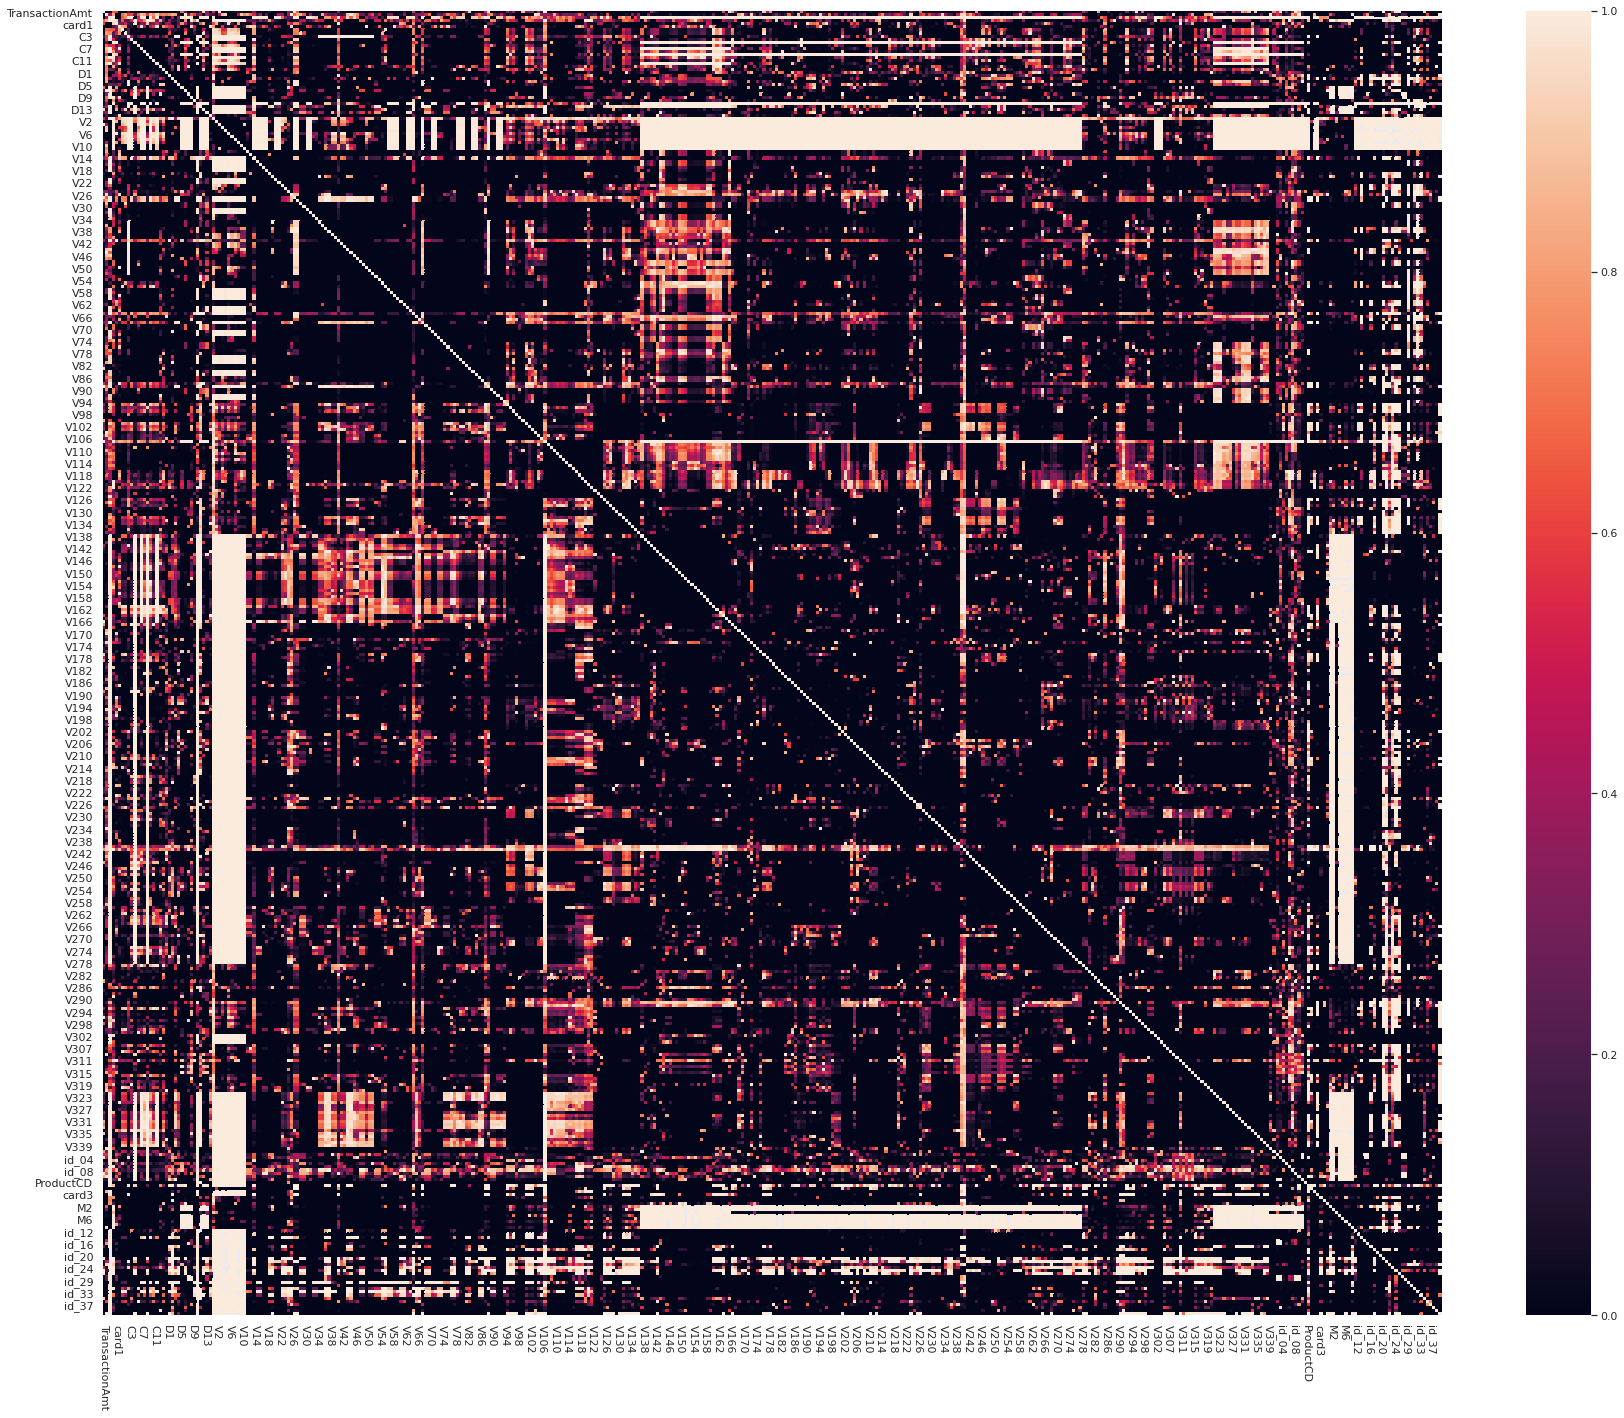

In [33]:
plt.figure(figsize=(30,24))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.xticks(rotation=270)
plt.show()

# Modeling

## Base Dataset

In [71]:
X_base = X.copy()

In [72]:
X_base = X_base[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'ProductCD', 'card4', 'card6']]

In [73]:
X_p = X_base[y==1]
X_n = X_base[y==0]

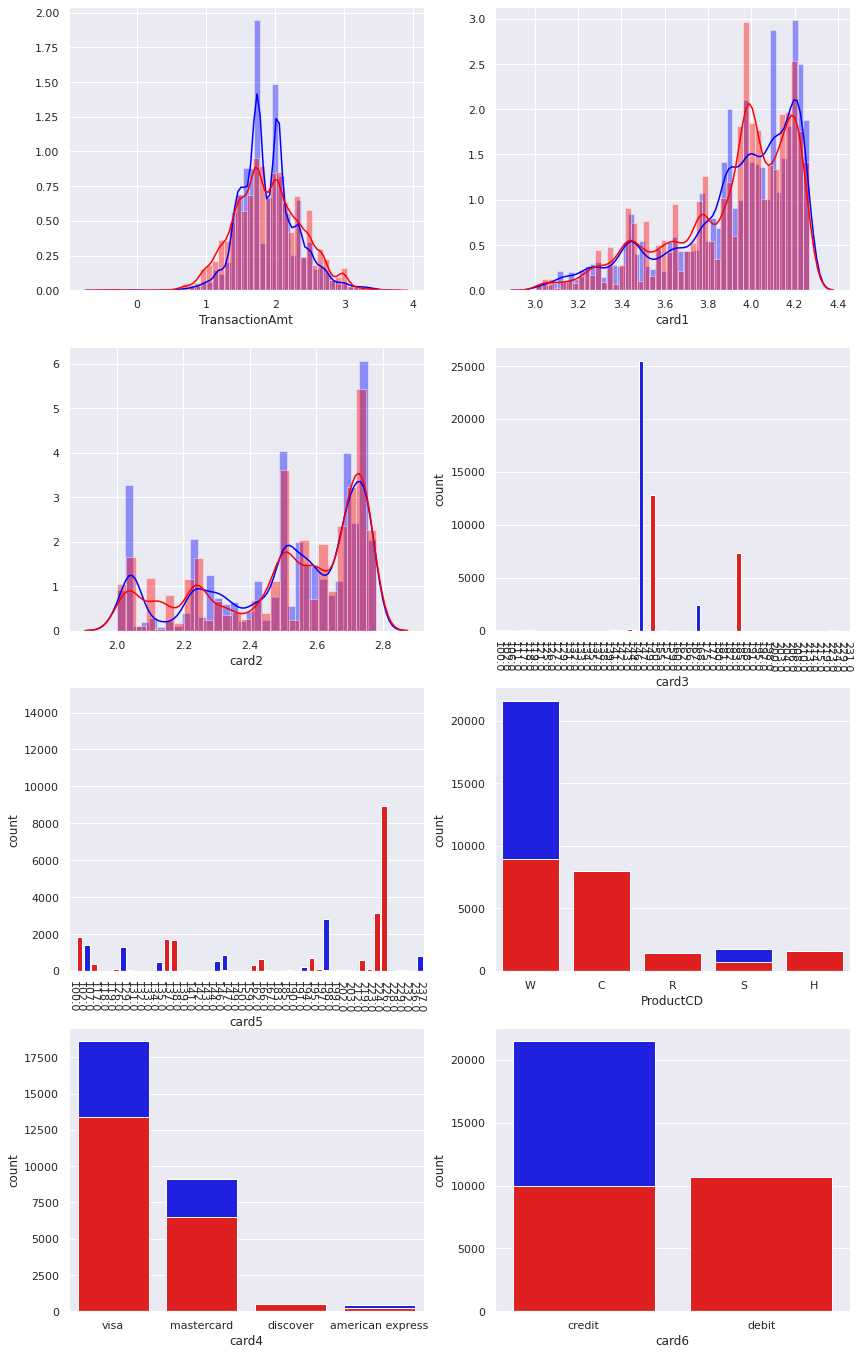

In [74]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,24))
sns.distplot(a=numpy.log10(X_n['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_p['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_n['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_n['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card2']), ax=ax[1,0], color='red')
sns.countplot(x='card3', data=X_n, ax=ax[1,1], color='blue')
sns.countplot(x='card3', data=X_p, ax=ax[1,1], color='red')
sns.countplot(x='card5', data=X_n, ax=ax[2,0], color='blue')
sns.countplot(x='card5', data=X_p, ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_n, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_p, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_n, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_p, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_n, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_p, ax=ax[3,1], color='red')
ax[1,1].tick_params(axis='x', labelrotation=270)
ax[2,0].tick_params(axis='x', labelrotation=270)

## Baseline Model

In [75]:
X_ = pandas.get_dummies(X_base, columns=['card3', 'card4','card5','card6', 'ProductCD'], drop_first=True)

In [76]:
X_.head()

,TransactionAmt,card1,card2,card3_102.0,card3_106.0,card3_111.0,card3_117.0,card3_118.0,card3_119.0,card3_120.0,...,card5_229.0,card5_232.0,card5_236.0,card5_237.0,card6_credit,card6_debit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2987240,37.098000,13413.0,103.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2987243,37.098000,13413.0,103.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2987245,37.098000,13413.0,103.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2987288,155.520996,16578.0,545.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [77]:
X_[['TransactionAmt','card1', 'card2']] = numpy.log10(X_[['TransactionAmt','card1', 'card2']]) 

In [78]:
X_.head()

,TransactionAmt,card1,card2,card3_102.0,card3_106.0,card3_111.0,card3_117.0,card3_118.0,card3_119.0,card3_120.0,...,card5_229.0,card5_232.0,card5_236.0,card5_237.0,card6_credit,card6_debit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2987240,1.569350,4.127526,2.012837,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2987243,1.569350,4.127526,2.012837,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2987245,1.569350,4.127526,2.012837,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2987288,2.191789,4.219532,2.736397,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [79]:
def ml_pipeline(X, y, n_splits, model, polynomial=False):
    
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, )
    
    if polynomial:
        pol = PolynomialFeatures(interaction_only=True)
        X = pol.fit_transform(X)
        
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'aucPR', 'aucROC','aucs'])
    output = Output(precision=0, recall=0, f1=0, aucPR=0, aucROC=0, aucs=[])
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
    
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
    
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)
        aucROC = roc_auc_score(y_true=y_test, y_score=y_probs)
        aucPR = auc(recalls, precisions)
        
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.aucPR += aucPR
        output.aucROC += aucROC
        output.aucs.append(aucPR)
        
        print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, aucPR: {aucPR:0.4f}, aucROC: {aucROC:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.aucPR /= n_splits
    output.aucROC /= n_splits
    
    print(f'Final - precision: {output.precision:0.4f}, recall: {output.recall:0.4f}, f1: {output.f1:0.4f}, aucPR: {output.aucPR:0.4f}, aucROC: {output.aucROC:0.4f}')
    
    return output

In [80]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
lr_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.6744, recall: 0.5181, f1: 0.5860, aucPR: 0.6822, aucROC: 0.7353
precision: 0.6864, recall: 0.5389, f1: 0.6038, aucPR: 0.6905, aucROC: 0.7416
precision: 0.7041, recall: 0.5365, f1: 0.6090, aucPR: 0.6910, aucROC: 0.7555
precision: 0.6902, recall: 0.5445, f1: 0.6088, aucPR: 0.6936, aucROC: 0.7527
precision: 0.7016, recall: 0.5373, f1: 0.6086, aucPR: 0.6997, aucROC: 0.7564
precision: 0.6727, recall: 0.5242, f1: 0.5892, aucPR: 0.6775, aucROC: 0.7409
precision: 0.6999, recall: 0.5532, f1: 0.6180, aucPR: 0.7067, aucROC: 0.7600
precision: 0.6812, recall: 0.5450, f1: 0.6055, aucPR: 0.6754, aucROC: 0.7419
precision: 0.6846, recall: 0.5368, f1: 0.6017, aucPR: 0.6917, aucROC: 0.7439
precision: 0.6786, recall: 0.5131, f1: 0.5843, aucPR: 0.6758, aucROC: 0.7427
Final - precision: 0.6874, recall: 0.5348, f1: 0.6015, aucPR: 0.6884, aucROC: 0.7471


## XGBoost

In [81]:
X_ = X_base.copy()

In [82]:
X_[['TransactionAmt', 'card1', 'card2']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2']])
X_[['card4', 'card6', 'ProductCD', 'card3', 'card5']] = X_[['card4', 'card6', 'ProductCD', 'card3', 'card5']].apply(LabelEncoder().fit_transform)

In [83]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [84]:
scores = output.get_booster().get_score(importance_type="gain")

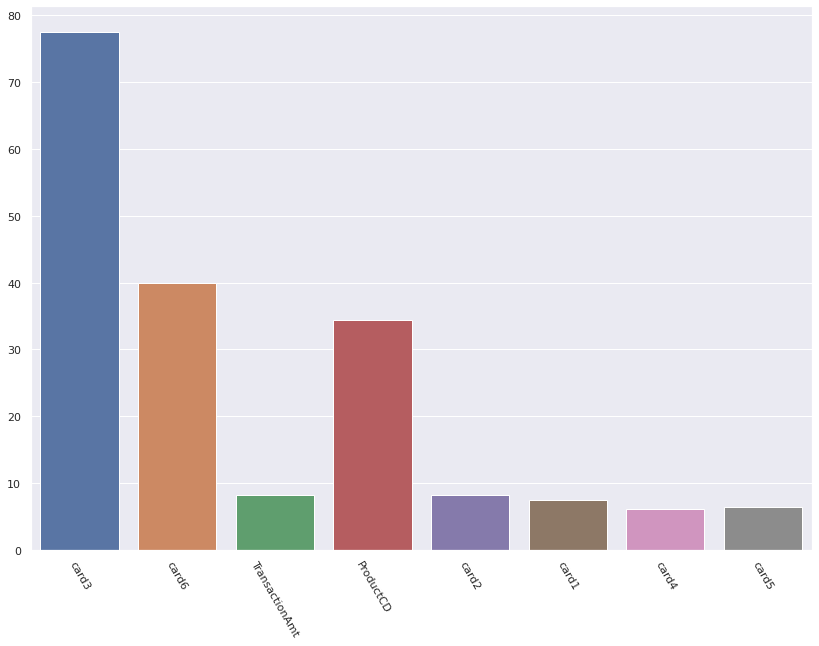

In [85]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [86]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7492, recall: 0.6575, f1: 0.7003, aucPR: 0.7862, aucROC: 0.8368
precision: 0.7610, recall: 0.6623, f1: 0.7082, aucPR: 0.8039, aucROC: 0.8472
precision: 0.7664, recall: 0.6841, f1: 0.7229, aucPR: 0.8091, aucROC: 0.8554
precision: 0.7605, recall: 0.6733, f1: 0.7142, aucPR: 0.8083, aucROC: 0.8530
precision: 0.7725, recall: 0.6655, f1: 0.7150, aucPR: 0.8127, aucROC: 0.8549
precision: 0.7592, recall: 0.6563, f1: 0.7040, aucPR: 0.7891, aucROC: 0.8403
precision: 0.7579, recall: 0.6592, f1: 0.7052, aucPR: 0.8031, aucROC: 0.8464
precision: 0.7599, recall: 0.6864, f1: 0.7213, aucPR: 0.7934, aucROC: 0.8448
precision: 0.7572, recall: 0.6655, f1: 0.7084, aucPR: 0.8032, aucROC: 0.8479
precision: 0.7499, recall: 0.6413, f1: 0.6914, aucPR: 0.7897, aucROC: 0.8424
Final - precision: 0.7594, recall: 0.6651, f1: 0.7091, aucPR: 0.7999, aucROC: 0.8469


In [87]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_poly = ml_pipeline(X=X_, y=y, n_splits=10, model=model, polynomial=True)

precision: 0.7507, recall: 0.6686, f1: 0.7073, aucPR: 0.7874, aucROC: 0.8415
precision: 0.7635, recall: 0.6792, f1: 0.7189, aucPR: 0.8090, aucROC: 0.8493
precision: 0.7660, recall: 0.6841, f1: 0.7227, aucPR: 0.8031, aucROC: 0.8542
precision: 0.7616, recall: 0.6975, f1: 0.7281, aucPR: 0.8151, aucROC: 0.8594
precision: 0.7688, recall: 0.6839, f1: 0.7239, aucPR: 0.8163, aucROC: 0.8596
precision: 0.7592, recall: 0.6578, f1: 0.7049, aucPR: 0.7920, aucROC: 0.8448
precision: 0.7665, recall: 0.6864, f1: 0.7242, aucPR: 0.8123, aucROC: 0.8569
precision: 0.7540, recall: 0.6868, f1: 0.7188, aucPR: 0.8014, aucROC: 0.8484
precision: 0.7671, recall: 0.6854, f1: 0.7239, aucPR: 0.8028, aucROC: 0.8527
precision: 0.7521, recall: 0.6801, f1: 0.7143, aucPR: 0.7929, aucROC: 0.8483
Final - precision: 0.7609, recall: 0.6810, f1: 0.7187, aucPR: 0.8032, aucROC: 0.8515


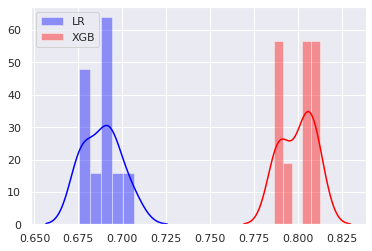

In [88]:
plt.figure()
sns.distplot(lr_base.aucs, color='blue', bins=5, label='LR')
sns.distplot(xgb_base.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [89]:
ttest_rel(lr_base.aucs, xgb_base.aucs)

Ttest_relResult(statistic=-53.4947590581696, pvalue=1.4011698035662338e-12)

## Feature Expansion

### C features

In [90]:
C = X.loc[:, 'C1':'C14']

In [91]:
C_p = C[y==1]
C_n = C[y==0]

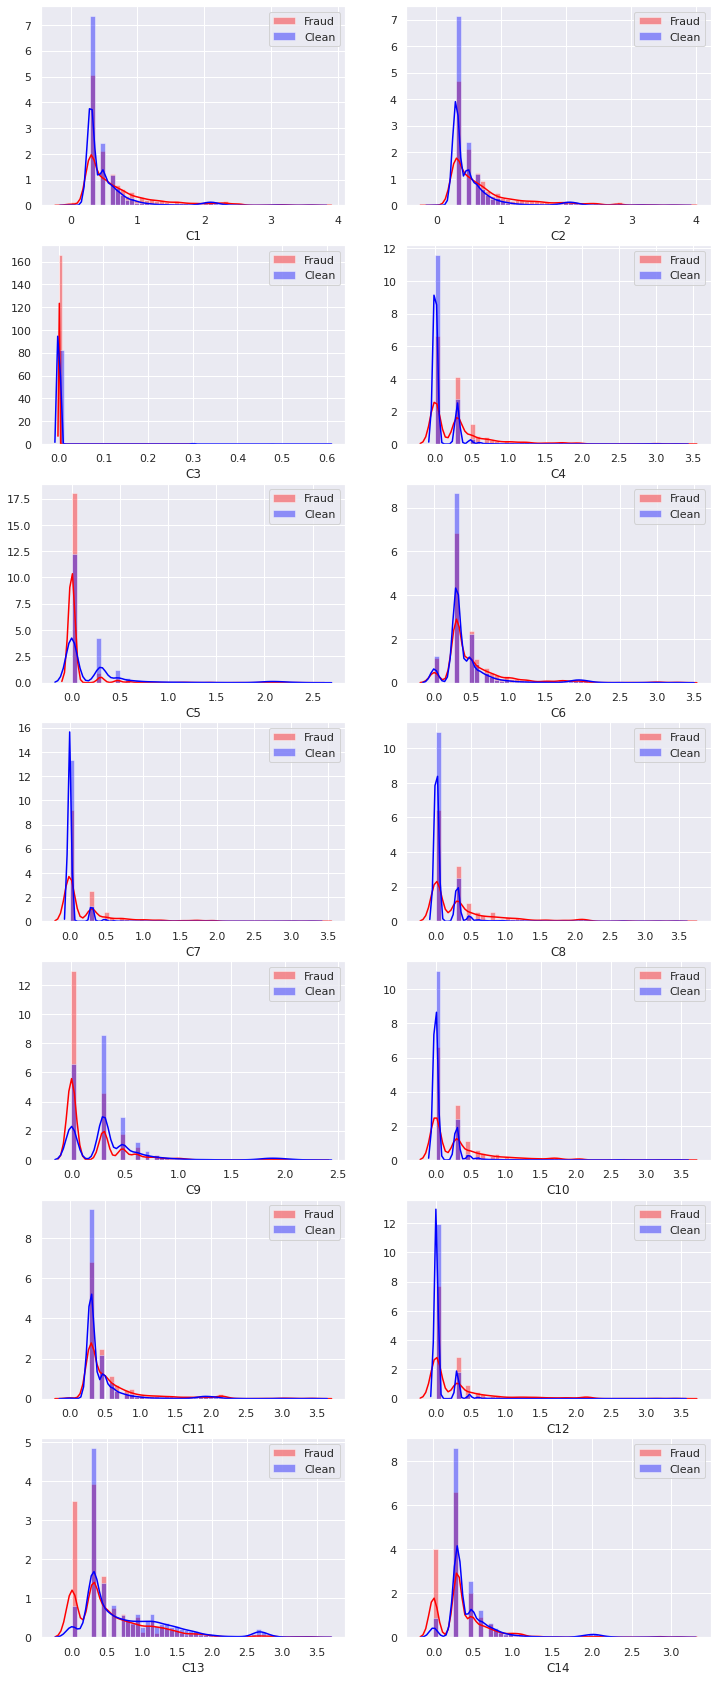

In [92]:

f, ax = plt.subplots(nrows=7, ncols=2, figsize=(12,30))

feature = 1
for row in range(0, 7):
    for col in range(0, 2):
        sns.distplot(numpy.log10(C_p[f'C{feature}'].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(C_n[f'C{feature}'].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        feature += 1
    

In [93]:
XC = X_base.join(C, how='inner')

In [94]:
XC.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [95]:
X_ = XC.copy()

In [96]:
X_[['TransactionAmt', 'card1', 'card2']] = numpy.log10(XC[['TransactionAmt', 'card1', 'card2']])
X_.loc[:, 'C1':'C14'] = numpy.log10(XC.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD']] = X_[['card3', 'card5', 'card4', 'card6', 'ProductCD']].apply(LabelEncoder().fit_transform)

In [97]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [98]:
scores = output.get_booster().get_score(importance_type="gain")

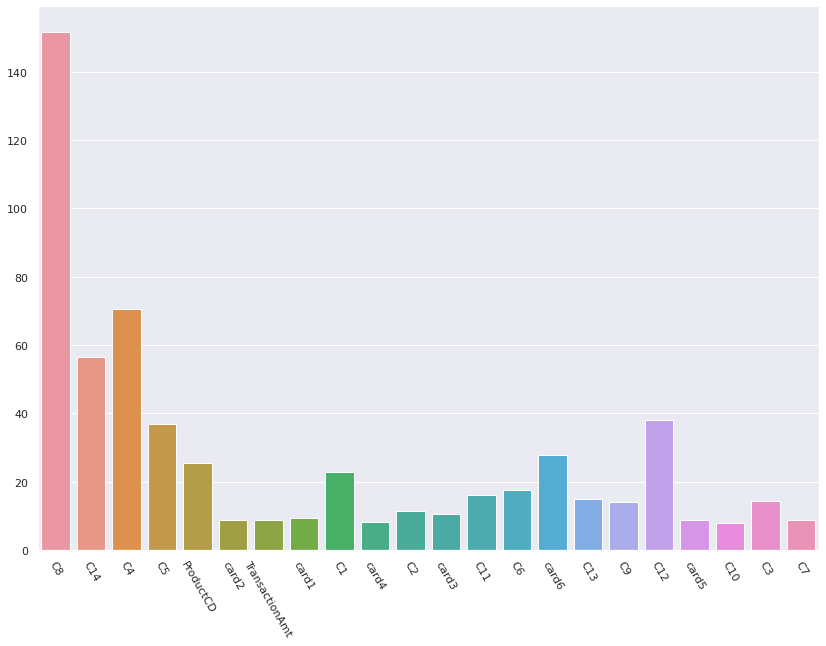

In [99]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [100]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,29,64,4,3,1,0.477121,0.477121,...,0.0,0.477121,0.00000,0.00000,0.477121,0.00000,0.30103,0.00000,0.69897,0.477121
2987240,1.569350,4.127526,2.012837,48,20,0,3,1,0.000000,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987243,1.569350,4.127526,2.012837,48,20,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987245,1.569350,4.127526,2.012837,48,20,0,3,1,0.477121,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987288,2.191789,4.219532,2.736397,48,64,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000


In [101]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_c = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8713, recall: 0.7731, f1: 0.8193, aucPR: 0.9153, aucROC: 0.9256
precision: 0.8722, recall: 0.7726, f1: 0.8194, aucPR: 0.9164, aucROC: 0.9257
precision: 0.8603, recall: 0.7837, f1: 0.8203, aucPR: 0.9196, aucROC: 0.9296
precision: 0.8726, recall: 0.7924, f1: 0.8305, aucPR: 0.9209, aucROC: 0.9336
precision: 0.8728, recall: 0.7773, f1: 0.8223, aucPR: 0.9190, aucROC: 0.9295
precision: 0.8767, recall: 0.7643, f1: 0.8167, aucPR: 0.9119, aucROC: 0.9232
precision: 0.8647, recall: 0.7546, f1: 0.8059, aucPR: 0.9103, aucROC: 0.9222
precision: 0.8473, recall: 0.7682, f1: 0.8058, aucPR: 0.9064, aucROC: 0.9192
precision: 0.8573, recall: 0.7561, f1: 0.8035, aucPR: 0.9065, aucROC: 0.9201
precision: 0.8582, recall: 0.7585, f1: 0.8052, aucPR: 0.9111, aucROC: 0.9216
Final - precision: 0.8653, recall: 0.7701, f1: 0.8149, aucPR: 0.9137, aucROC: 0.9250


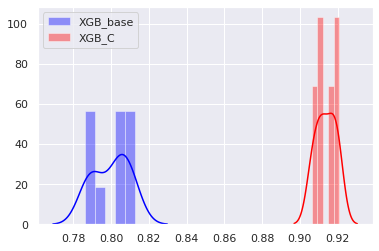

In [102]:
plt.figure()
sns.distplot(xgb_base.aucs, color='blue', bins=5, label='XGB_base')
sns.distplot(xgb_c.aucs, color='red', bins=5, label='XGB_C')
plt.legend()

In [103]:
ttest_rel(xgb_base.aucs, xgb_c.aucs)

Ttest_relResult(statistic=-44.03105327337561, pvalue=8.031753333671718e-12)

In [104]:
C_sum = X_[[f'C{i}' for i in range(1,15)]].sum(axis=1)

In [105]:
X_['C_sum'] = C_sum
X_.drop(columns=[f'C{i}' for i in range(1,15)], inplace=True)

In [106]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C_sum
TransactionID,,,,,,,,,
2987203,2.648360,4.261691,2.765669,29,64,4,3,1,3.385606
2987240,1.569350,4.127526,2.012837,48,20,0,3,1,2.408240
2987243,1.569350,4.127526,2.012837,48,20,0,3,1,2.709270
2987245,1.569350,4.127526,2.012837,48,20,0,3,1,2.885361
2987288,2.191789,4.219532,2.736397,48,64,0,3,1,2.709270


In [48]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8148, recall: 0.6855, f1: 0.7446, aucPR: 0.8539, aucROC: 0.8845
precision: 0.7960, recall: 0.6986, f1: 0.7441, aucPR: 0.8395, aucROC: 0.8702
precision: 0.8089, recall: 0.7107, f1: 0.7566, aucPR: 0.8586, aucROC: 0.8848
precision: 0.8152, recall: 0.7154, f1: 0.7621, aucPR: 0.8634, aucROC: 0.8904
precision: 0.8054, recall: 0.7014, f1: 0.7498, aucPR: 0.8480, aucROC: 0.8774
precision: 0.8084, recall: 0.6883, f1: 0.7435, aucPR: 0.8454, aucROC: 0.8717
precision: 0.8034, recall: 0.6922, f1: 0.7436, aucPR: 0.8481, aucROC: 0.8765
precision: 0.8159, recall: 0.7057, f1: 0.7568, aucPR: 0.8555, aucROC: 0.8822
precision: 0.8183, recall: 0.6955, f1: 0.7520, aucPR: 0.8528, aucROC: 0.8833
precision: 0.7871, recall: 0.6801, f1: 0.7297, aucPR: 0.8408, aucROC: 0.8691
Final - precision: 0.8074, recall: 0.6973, f1: 0.7483, aucPR: 0.8506, aucROC: 0.8790


### Adress features

In [107]:
G = X[['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']]

In [108]:
G.head()

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,
2987203,251.000000,87.0,133.011108,215.635406,aol.com,gmail.com
2987240,291.504517,87.0,133.011108,215.635406,hotmail.com,hotmail.com
2987243,291.504517,87.0,133.011108,215.635406,hotmail.com,hotmail.com
2987245,291.504517,87.0,133.011108,215.635406,hotmail.com,hotmail.com
2987288,291.504517,87.0,133.011108,215.635406,outlook.com,outlook.com


In [109]:
G_p = G[y==1]
G_n = G[y==0]

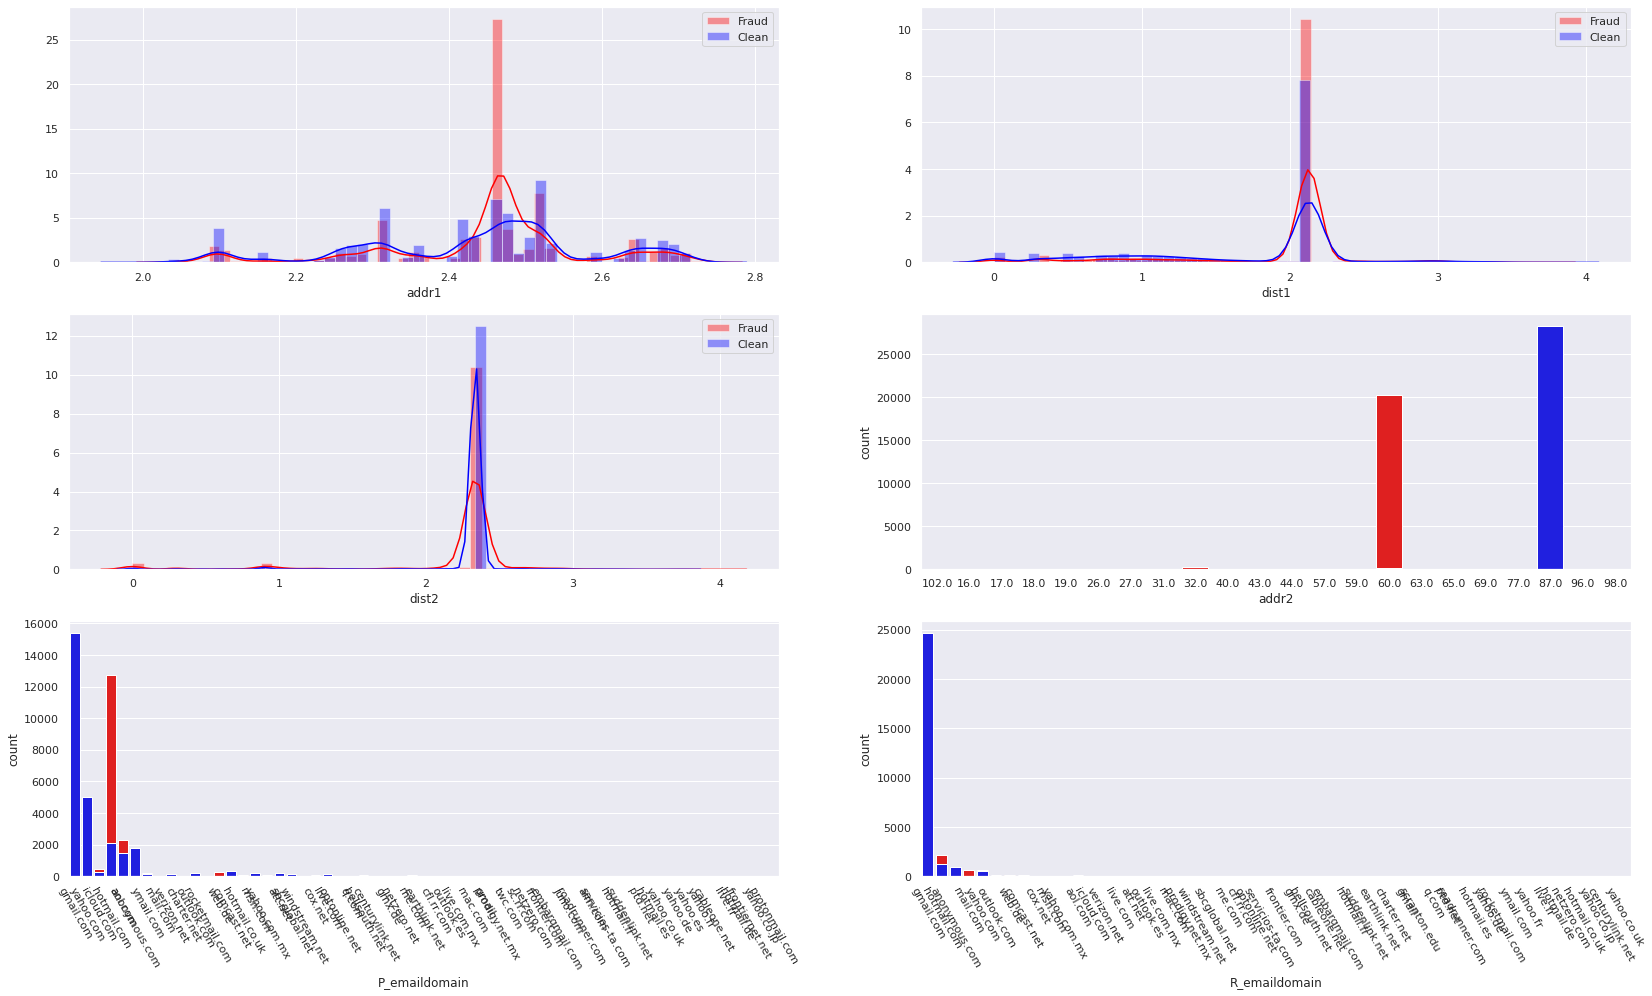

In [110]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(28,16))

features = ['addr1', 'dist1', 'dist2']
idx = 0
for row in range(0, 2):
    for col in range(0, 2):
        if idx < 3:
            sns.distplot(numpy.log10(G_p[features[idx]].add(1)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(G_n[features[idx]].add(1)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            idx += 1
            
sns.countplot(G_p['addr2'], color='red', ax=ax[1, 1], label='Fraud')
sns.countplot(G_n['addr2'], color='blue', ax=ax[1, 1], label='Clean')
sns.countplot(G_p['P_emaildomain'], color='red', ax=ax[2, 0], label='Fraud')
sns.countplot(G_n['P_emaildomain'], color='blue', ax=ax[2, 0], label='Clean')
sns.countplot(G_p['R_emaildomain'], color='red', ax=ax[2, 1], label='Fraud')
sns.countplot(G_n['R_emaildomain'], color='blue', ax=ax[2, 1], label='Clean')
ax[2,1].tick_params(axis='x', labelrotation=300)
ax[2,0].tick_params(axis='x', labelrotation=300)
plt.show()

In [111]:
XCG = XC.join(G, how='inner')

In [112]:
XCG.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,1.0,0.0,4.0,2.0,251.000000,87.0,133.011108,215.635406,aol.com,gmail.com
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,1.0,1.0,0.0,0.0,291.504517,87.0,133.011108,215.635406,hotmail.com,hotmail.com
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,291.504517,87.0,133.011108,215.635406,hotmail.com,hotmail.com
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,1.0,1.0,0.0,0.0,291.504517,87.0,133.011108,215.635406,hotmail.com,hotmail.com
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,291.504517,87.0,133.011108,215.635406,outlook.com,outlook.com


In [113]:
X_ = XCG.copy()

In [114]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)

In [115]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,0.30103,0.00000,0.69897,0.477121,2.401401,30,2.127141,2.335729,2,15
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466133,30,2.127141,2.335729,19,18
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466133,30,2.127141,2.335729,19,18
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466133,30,2.127141,2.335729,19,18
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466133,30,2.127141,2.335729,35,33


In [116]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [117]:
scores = output.get_booster().get_score(importance_type="gain")

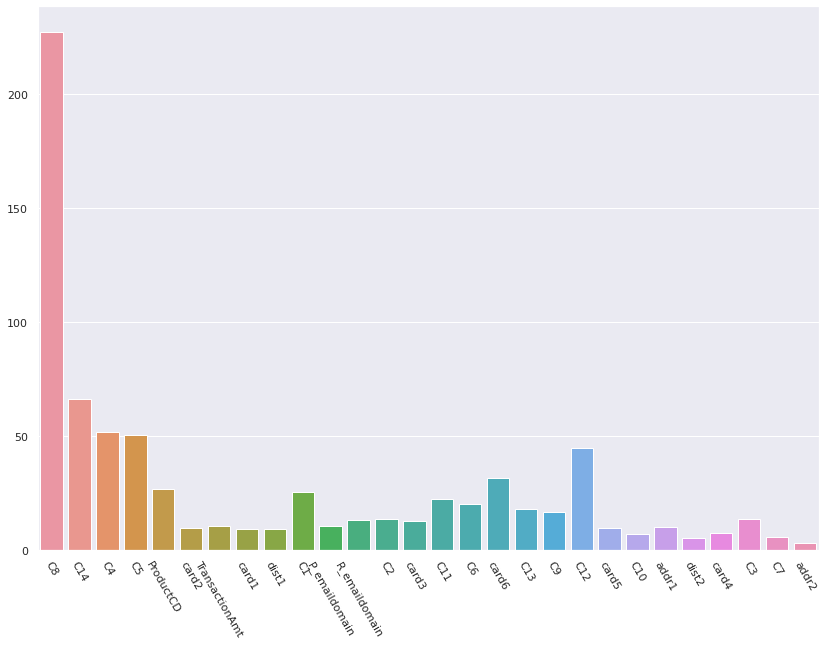

In [118]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [119]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cg = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8787, recall: 0.7813, f1: 0.8271, aucPR: 0.9221, aucROC: 0.9325
precision: 0.8720, recall: 0.7847, f1: 0.8261, aucPR: 0.9215, aucROC: 0.9304
precision: 0.8788, recall: 0.7896, f1: 0.8318, aucPR: 0.9240, aucROC: 0.9354
precision: 0.8796, recall: 0.7957, f1: 0.8356, aucPR: 0.9281, aucROC: 0.9394
precision: 0.8742, recall: 0.7938, f1: 0.8321, aucPR: 0.9253, aucROC: 0.9341
precision: 0.8887, recall: 0.7807, f1: 0.8312, aucPR: 0.9201, aucROC: 0.9311
precision: 0.8723, recall: 0.7740, f1: 0.8202, aucPR: 0.9183, aucROC: 0.9283
precision: 0.8531, recall: 0.7759, f1: 0.8127, aucPR: 0.9128, aucROC: 0.9243
precision: 0.8613, recall: 0.7754, f1: 0.8161, aucPR: 0.9173, aucROC: 0.9306
precision: 0.8714, recall: 0.7803, f1: 0.8233, aucPR: 0.9204, aucROC: 0.9304
Final - precision: 0.8730, recall: 0.7831, f1: 0.8256, aucPR: 0.9210, aucROC: 0.9317


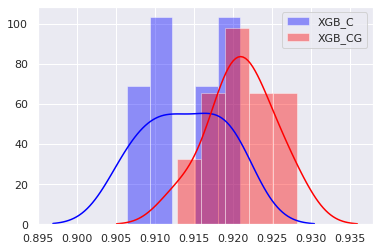

In [120]:
plt.figure()
sns.distplot(xgb_c.aucs, color='blue', bins=5, label='XGB_C')
sns.distplot(xgb_cg.aucs, color='red', bins=5, label='XGB_CG')
plt.legend()

In [121]:
ttest_rel(xgb_cg.aucs, xgb_c.aucs)

Ttest_relResult(statistic=12.0491212323349, pvalue=7.43649800493713e-07)

### M features

In [122]:
features = [f'M{i}' for i in range(1,10)]

In [123]:
M = X.loc[:, features]

In [124]:
M.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987203,T,T,T,M0,F,T,F,F,T
2987240,T,T,T,M2,F,F,F,F,T
2987243,T,T,T,M2,F,F,F,F,T
2987245,T,T,T,M2,F,F,F,F,T
2987288,T,T,T,M2,F,F,F,F,T


In [125]:
M_p = M[y==1]
M_n = M[y==0]

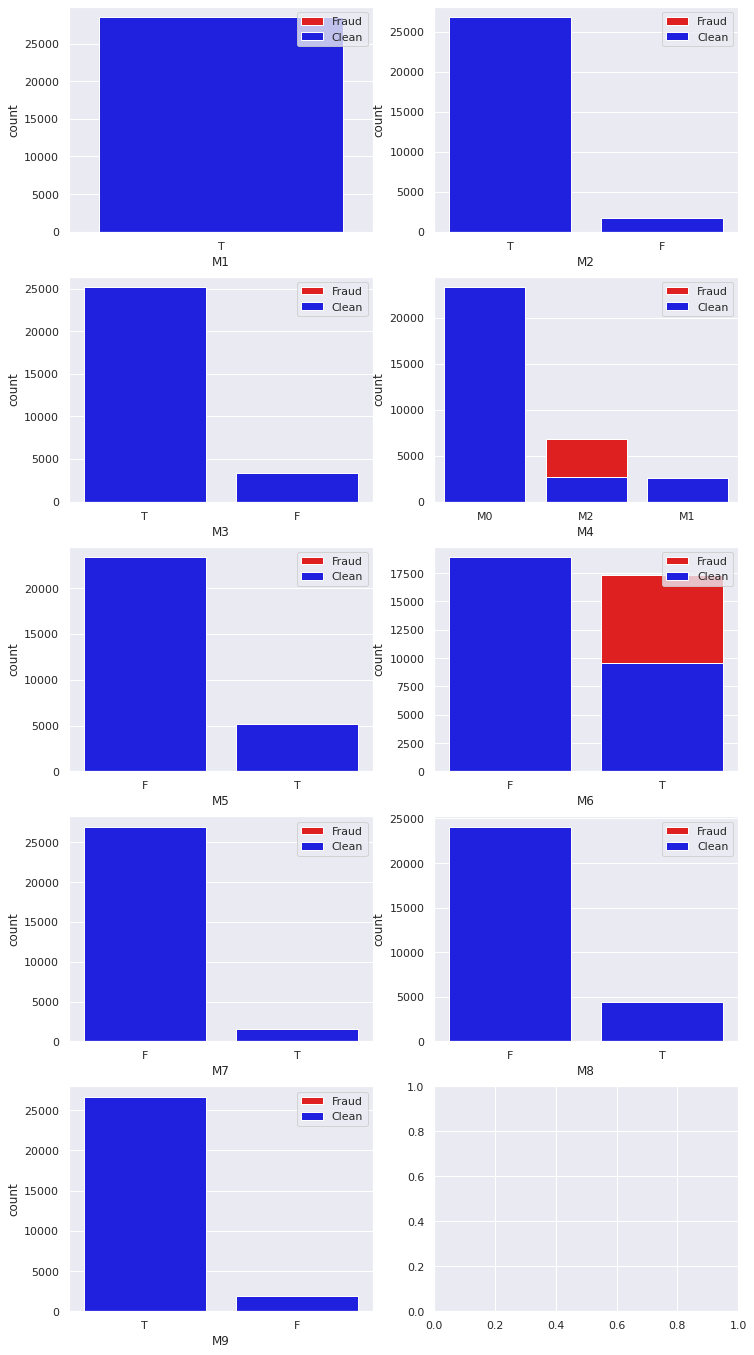

In [126]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))

feature = 1
for row in range(0, 5):
    for col in range(0, 2):
        if feature < 10:
            sns.countplot(M_p[f'M{feature}'], color='red', ax=ax[row,col], label='Fraud')
            sns.countplot(M_n[f'M{feature}'], color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1


In [127]:
XCGM = XCG.join(M, how='inner')

In [128]:
XCGM.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,gmail.com,T,T,T,M0,F,T,F,F,T
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,outlook.com,T,T,T,M2,F,F,F,F,T


In [129]:
X_ = XCGM.copy()

In [130]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)

In [131]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,15,0,1,1,0,0,1,0,0,1
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,33,0,1,1,2,0,0,0,0,1


In [132]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [133]:
scores = output.get_booster().get_score(importance_type="gain")

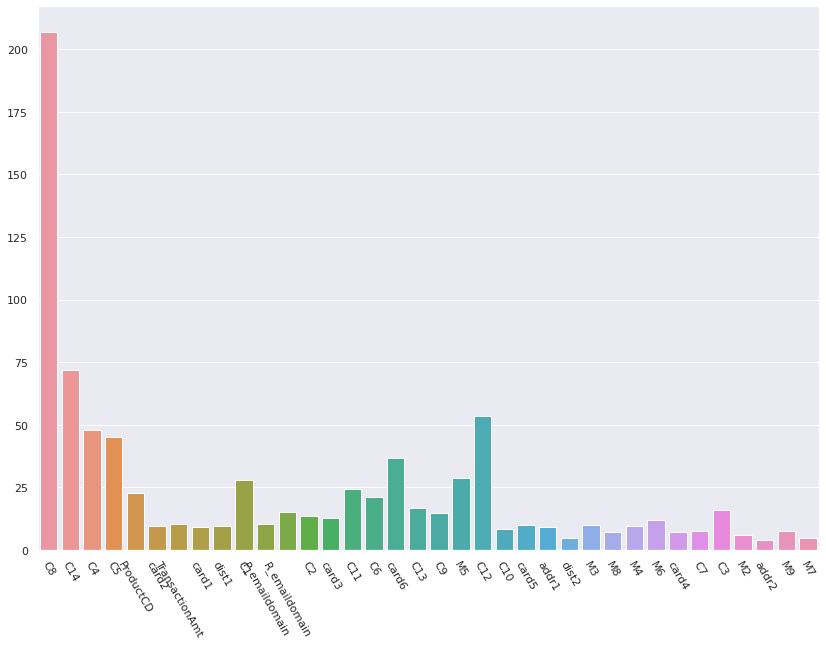

In [134]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [135]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgm = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8823, recall: 0.7939, f1: 0.8358, aucPR: 0.9236, aucROC: 0.9333
precision: 0.8807, recall: 0.7997, f1: 0.8382, aucPR: 0.9277, aucROC: 0.9363
precision: 0.8747, recall: 0.8007, f1: 0.8361, aucPR: 0.9271, aucROC: 0.9374
precision: 0.8848, recall: 0.8103, f1: 0.8459, aucPR: 0.9317, aucROC: 0.9417
precision: 0.8798, recall: 0.8006, f1: 0.8383, aucPR: 0.9282, aucROC: 0.9383
precision: 0.8870, recall: 0.7899, f1: 0.8356, aucPR: 0.9215, aucROC: 0.9320
precision: 0.8722, recall: 0.7861, f1: 0.8269, aucPR: 0.9224, aucROC: 0.9331
precision: 0.8558, recall: 0.7870, f1: 0.8200, aucPR: 0.9170, aucROC: 0.9291
precision: 0.8732, recall: 0.7832, f1: 0.8257, aucPR: 0.9220, aucROC: 0.9338
precision: 0.8750, recall: 0.7928, f1: 0.8319, aucPR: 0.9232, aucROC: 0.9325
Final - precision: 0.8765, recall: 0.7944, f1: 0.8334, aucPR: 0.9244, aucROC: 0.9348


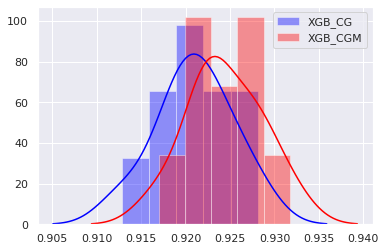

In [136]:
plt.figure()
sns.distplot(xgb_cg.aucs, color='blue', bins=5, label='XGB_CG')
sns.distplot(xgb_cgm.aucs, color='red', bins=5, label='XGB_CGM')
plt.legend()

In [137]:
ttest_rel(xgb_cgm.aucs, xgb_cg.aucs)

Ttest_relResult(statistic=7.61304608467786, pvalue=3.28191799404858e-05)

### D features

In [138]:
features = [f'D{i}' for i in range(1,16)]

In [139]:
D = X.loc[:, features]

In [140]:
D.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,
2987203,57.0,57.000000,52.000000,0.0,29.892075,52.910919,18.296387,81.053474,0.532864,80.0,129.170425,46.310261,9.635795,55.106064,374.0
2987240,0.0,139.445282,22.284016,0.0,29.892075,0.000000,18.296387,45.041664,0.041666,0.0,129.170425,0.000000,0.000000,0.000000,0.0
2987243,0.0,139.445282,22.284016,0.0,0.000000,0.000000,0.000000,45.041664,0.041666,0.0,129.170425,0.000000,0.000000,0.000000,0.0
2987245,0.0,139.445282,22.284016,0.0,0.000000,0.000000,0.000000,45.041664,0.041666,0.0,129.170425,0.000000,0.000000,0.000000,0.0
2987288,0.0,139.445282,22.284016,0.0,29.892075,0.000000,18.296387,81.053474,0.532864,0.0,129.170425,0.000000,0.000000,0.000000,0.0


In [141]:
D_p = D[y==1]
D_n = D[y==0]

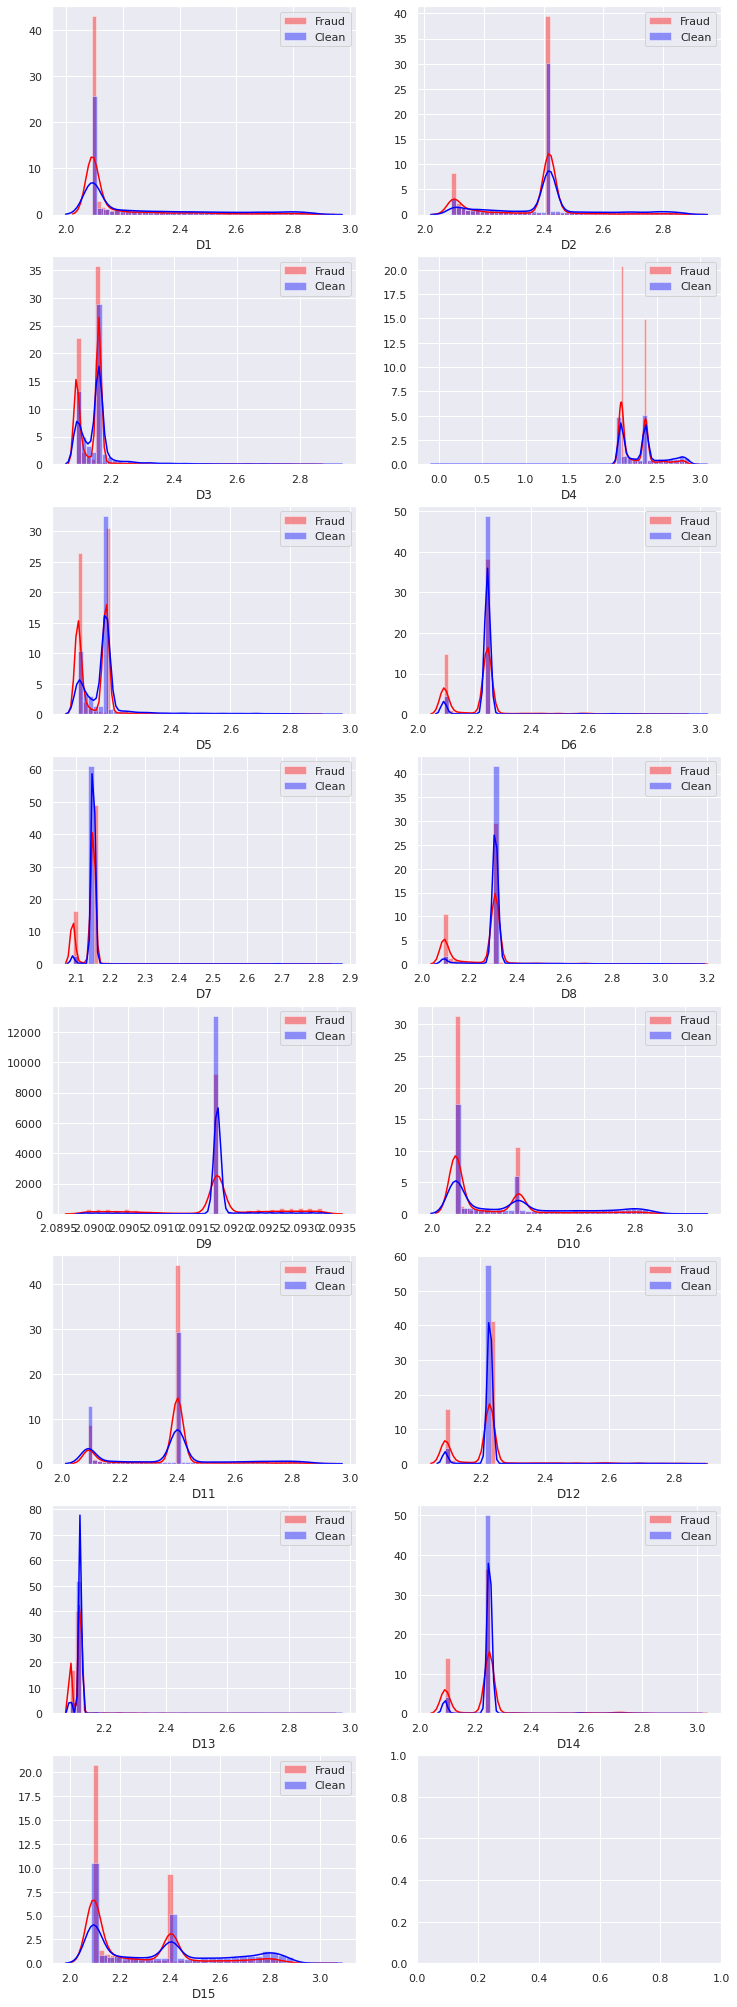

In [149]:
f, ax = plt.subplots(nrows=8, ncols=2, figsize=(12, 36))

feature = 1
for row in range(0, 8):
    for col in range(0, 2):
        if feature < 16:
            sns.distplot(numpy.log10(D_p[f'D{feature}'].add(123)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(D_n[f'D{feature}'].add(123)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1

In [150]:
XCGMD = XCGM.join(D, how='inner')

In [151]:
XCGMD.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,52.910919,18.296387,81.053474,0.532864,80.0,129.170425,46.310261,9.635795,55.106064,374.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.000000,18.296387,45.041664,0.041666,0.0,129.170425,0.000000,0.000000,0.000000,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.000000,0.000000,45.041664,0.041666,0.0,129.170425,0.000000,0.000000,0.000000,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.000000,0.000000,45.041664,0.041666,0.0,129.170425,0.000000,0.000000,0.000000,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.000000,18.296387,81.053474,0.532864,0.0,129.170425,0.000000,0.000000,0.000000,0.0


In [152]:
X_ = XCGMD.copy()

In [153]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(123))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)
X_.loc[:, 'D1':'D15'] = numpy.log10(X_.loc[:, 'D1':'D15'].add(123))

In [154]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,2.096910,2.096910,...,2.245293,2.150131,2.309744,2.091783,2.307496,2.401694,2.228683,2.122661,2.250679,2.696356
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,2.089905,2.093422,...,2.089905,2.150131,2.225417,2.090052,2.089905,2.401694,2.089905,2.089905,2.089905,2.089905
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,2.093422,2.093422,...,2.089905,2.089905,2.225417,2.090052,2.089905,2.401694,2.089905,2.089905,2.089905,2.089905
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,2.096910,2.093422,...,2.089905,2.089905,2.225417,2.090052,2.089905,2.401694,2.089905,2.089905,2.089905,2.089905
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,2.093422,2.093422,...,2.089905,2.150131,2.309744,2.091783,2.089905,2.401694,2.089905,2.089905,2.089905,2.089905


In [155]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [156]:
scores = output.get_booster().get_score(importance_type="gain")

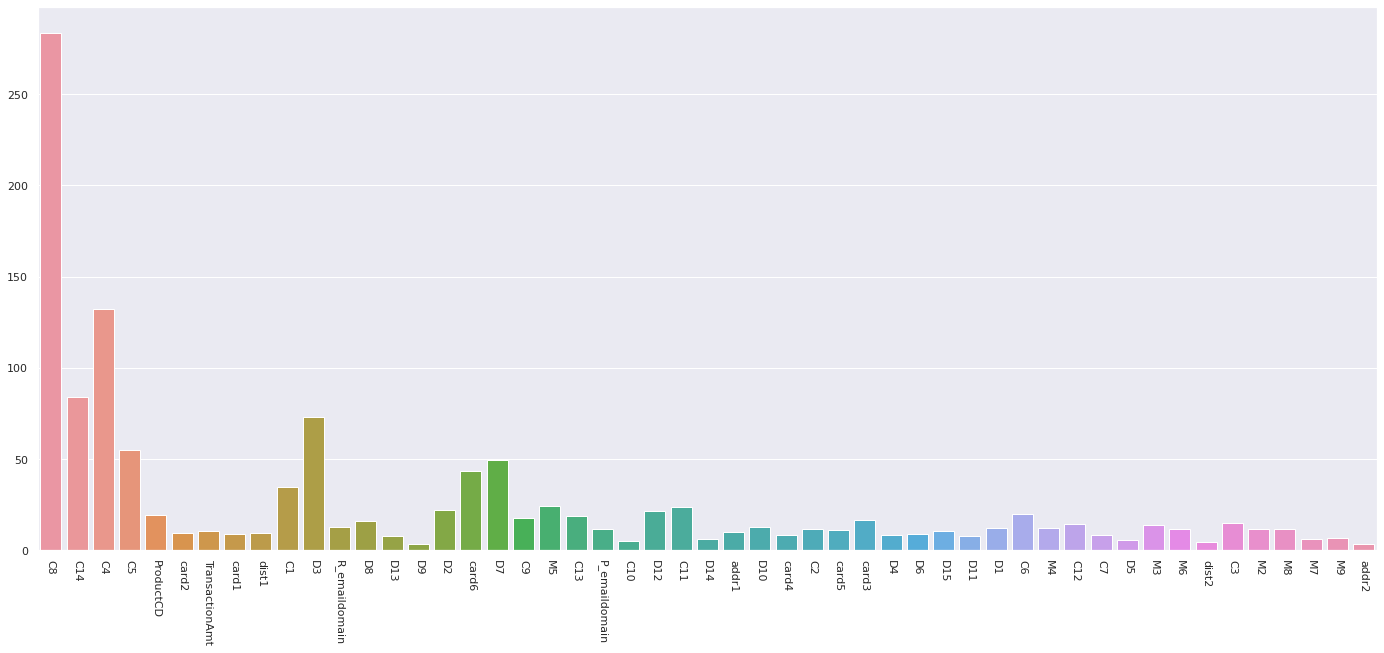

In [157]:
plt.figure(figsize=(24,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=270)
plt.show()

In [158]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmd = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8919, recall: 0.8181, f1: 0.8534, aucPR: 0.9356, aucROC: 0.9420
precision: 0.8889, recall: 0.8050, f1: 0.8449, aucPR: 0.9314, aucROC: 0.9389
precision: 0.8849, recall: 0.8186, f1: 0.8505, aucPR: 0.9333, aucROC: 0.9411
precision: 0.8776, recall: 0.8291, f1: 0.8527, aucPR: 0.9355, aucROC: 0.9451
precision: 0.8822, recall: 0.8156, f1: 0.8476, aucPR: 0.9331, aucROC: 0.9415
precision: 0.8929, recall: 0.8030, f1: 0.8456, aucPR: 0.9298, aucROC: 0.9362
precision: 0.8697, recall: 0.8011, f1: 0.8340, aucPR: 0.9256, aucROC: 0.9357
precision: 0.8668, recall: 0.8161, f1: 0.8407, aucPR: 0.9284, aucROC: 0.9387
precision: 0.8743, recall: 0.8146, f1: 0.8434, aucPR: 0.9284, aucROC: 0.9397
precision: 0.8701, recall: 0.8074, f1: 0.8376, aucPR: 0.9278, aucROC: 0.9371
Final - precision: 0.8799, recall: 0.8129, f1: 0.8450, aucPR: 0.9309, aucROC: 0.9396


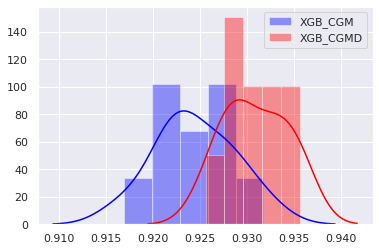

In [159]:
plt.figure()
sns.distplot(xgb_cgm.aucs, color='blue', bins=5, label='XGB_CGM')
sns.distplot(xgb_cgmd.aucs, color='red', bins=5, label='XGB_CGMD')
plt.legend()

In [160]:
ttest_rel(xgb_cgmd.aucs, xgb_cgm.aucs)

Ttest_relResult(statistic=6.441568156551022, pvalue=0.00011931250379538632)

## V features

In [161]:
features = [f'V{i}' for i in range(1,340)]

In [162]:
V = X[features]

In [163]:
V.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,0.999953,1.058308,1.111746,0.861043,0.914153,1.053953,1.090155,1.035313,1.058824,0.388207,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987240,0.999953,1.058308,1.111746,0.861043,0.914153,1.053953,1.090155,1.035313,1.058824,0.388207,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987243,0.999953,1.058308,1.111746,0.861043,0.914153,1.053953,1.090155,1.035313,1.058824,0.388207,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987245,0.999953,1.058308,1.111746,0.861043,0.914153,1.053953,1.090155,1.035313,1.058824,0.388207,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987288,0.999953,1.058308,1.111746,0.861043,0.914153,1.053953,1.090155,1.035313,1.058824,0.388207,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691


In [164]:
XCGMDV = XCGMD.join(V, how='inner')

In [165]:
XCGMDV.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.576204,402.634247,793.719238,592.884949,8.709266,52.973019,26.281916,41.669518,101.527504,70.533691


In [166]:
X_ = XCGMDV.copy()

In [167]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(123))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)
X_.loc[:, 'D1':'D15'] = numpy.log10(X_.loc[:, 'D1':'D15'].add(123))
X_.loc[:, 'V1':'V339'] = numpy.log10(X_.loc[:, 'V1':'V339'].add(123))

In [168]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,2.096910,2.096910,...,2.091935,2.720684,2.962236,2.854843,2.119616,2.245446,2.174007,2.216613,2.35127,2.286757
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,2.089905,2.093422,...,2.091935,2.720684,2.962236,2.854843,2.119616,2.245446,2.174007,2.216613,2.35127,2.286757
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,2.093422,2.093422,...,2.091935,2.720684,2.962236,2.854843,2.119616,2.245446,2.174007,2.216613,2.35127,2.286757
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,2.096910,2.093422,...,2.091935,2.720684,2.962236,2.854843,2.119616,2.245446,2.174007,2.216613,2.35127,2.286757
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,2.093422,2.093422,...,2.091935,2.720684,2.962236,2.854843,2.119616,2.245446,2.174007,2.216613,2.35127,2.286757


In [169]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [170]:
scores = output.get_booster().get_score(importance_type="gain")

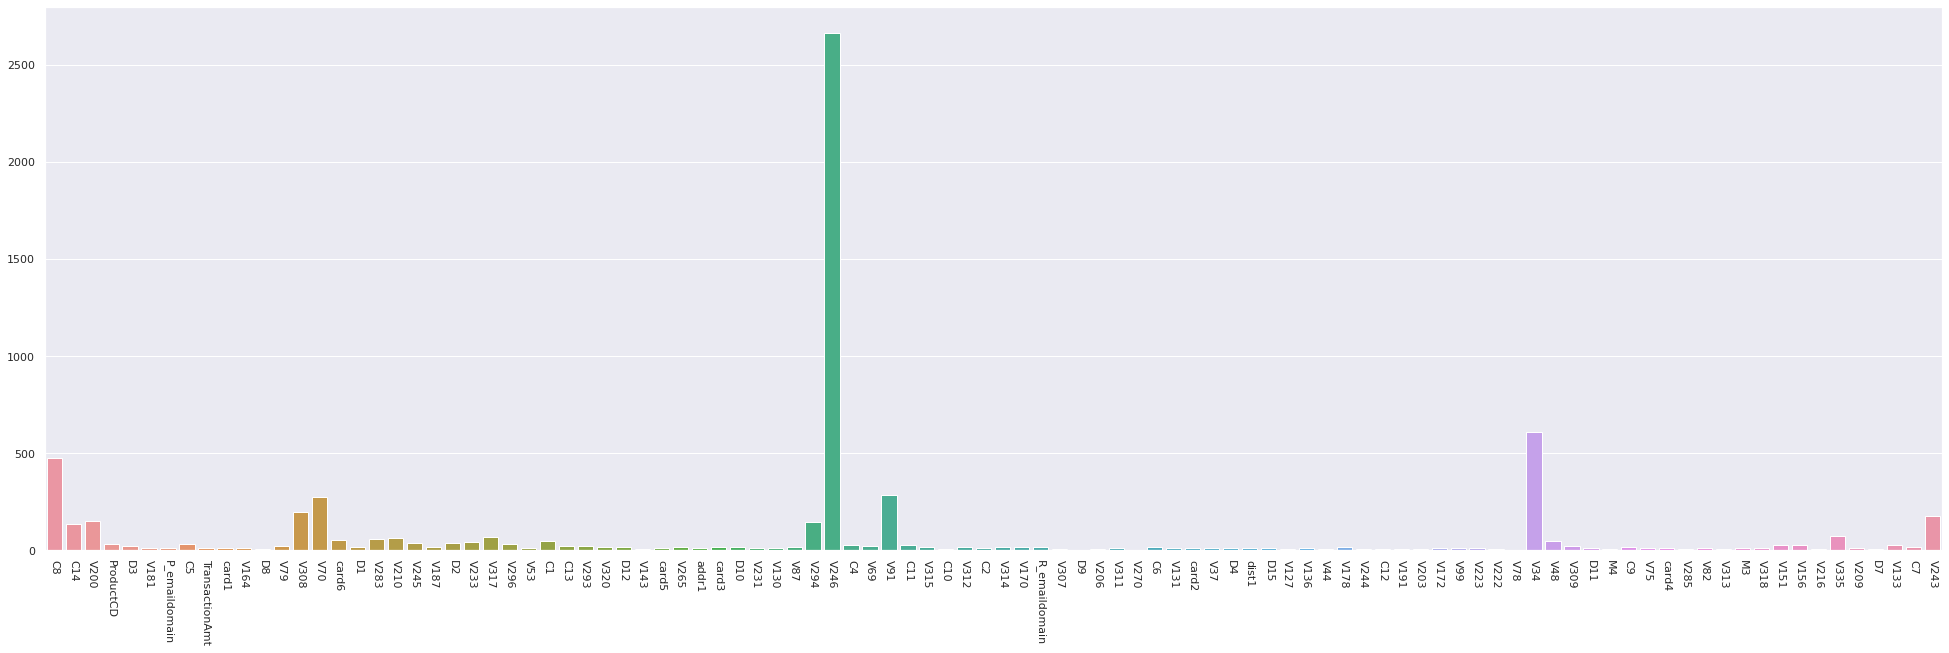

In [171]:
plt.figure(figsize=(34,10))
sns.barplot(x=list(scores.keys())[0:100], y=list(scores.values())[0:100])
plt.xticks(rotation=270)
plt.show()

In [172]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmdv = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8736, recall: 0.7958, f1: 0.8329, aucPR: 0.9311, aucROC: 0.9377
precision: 0.8804, recall: 0.8016, f1: 0.8392, aucPR: 0.9269, aucROC: 0.9335
precision: 0.8723, recall: 0.8031, f1: 0.8363, aucPR: 0.9306, aucROC: 0.9394
precision: 0.8820, recall: 0.8209, f1: 0.8503, aucPR: 0.9330, aucROC: 0.9421
precision: 0.8772, recall: 0.8059, f1: 0.8401, aucPR: 0.9305, aucROC: 0.9389
precision: 0.8899, recall: 0.7861, f1: 0.8347, aucPR: 0.9253, aucROC: 0.9320
precision: 0.8774, recall: 0.7967, f1: 0.8351, aucPR: 0.9278, aucROC: 0.9347
precision: 0.8722, recall: 0.8059, f1: 0.8377, aucPR: 0.9268, aucROC: 0.9369
precision: 0.8757, recall: 0.8011, f1: 0.8367, aucPR: 0.9311, aucROC: 0.9398
precision: 0.8782, recall: 0.7957, f1: 0.8349, aucPR: 0.9289, aucROC: 0.9375
Final - precision: 0.8779, recall: 0.8013, f1: 0.8378, aucPR: 0.9292, aucROC: 0.9372


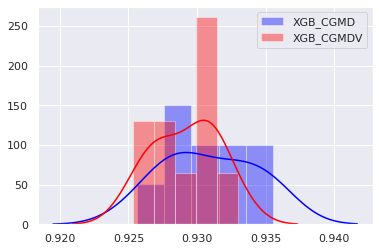

In [173]:
plt.figure()
sns.distplot(xgb_cgmd.aucs, color='blue', bins=5, label='XGB_CGMD')
sns.distplot(xgb_cgmdv.aucs, color='red', bins=5, label='XGB_CGMDV')
plt.legend()

In [174]:
ttest_rel(xgb_cgmd.aucs, xgb_cgmdv.aucs)

Ttest_relResult(statistic=1.951151720769967, pvalue=0.08281339484549159)

## Identity features

In [42]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.000000,87.0,...,chrome 63.0,24.0,1920x1080,match_status:2,F,F,T,F,desktop,Windows
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,291.504517,87.0,...,chrome 54.0 for android,24.0,1920x1080,match_status:2,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,291.504517,87.0,...,chrome 54.0 for android,24.0,1920x1080,match_status:2,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,291.504517,87.0,...,chrome 54.0 for android,24.0,1920x1080,match_status:2,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,291.504517,87.0,...,chrome 62.0 for ios,24.0,1920x1080,match_status:2,F,F,F,F,mobile,Windows


In [53]:
X_ = X.copy()

In [52]:
min([i for i in X_[numerical].values.flatten() if i<0])

-122.0

In [55]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)
X_.loc[:, numerical] = numpy.log10(X_[numerical].add(123))

In [56]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.754348,4,4.264605,2.848805,29,3,64,1,2.572872,30,...,38,2,46,2,0,0,1,0,0,660
2987240,2.204386,0,4.131490,2.354108,48,3,20,1,2.617529,30,...,20,2,46,2,0,0,1,1,1,385
2987243,2.204386,0,4.131490,2.354108,48,3,20,1,2.617529,30,...,20,2,46,2,0,0,1,1,1,385
2987245,2.204386,0,4.131490,2.354108,48,3,20,1,2.617529,30,...,20,2,46,2,0,0,1,1,1,385
2987288,2.444858,0,4.222742,2.824776,48,3,64,1,2.617529,30,...,37,2,46,2,0,0,0,0,1,660


In [57]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [58]:
scores = output.get_booster().get_score(importance_type="gain")

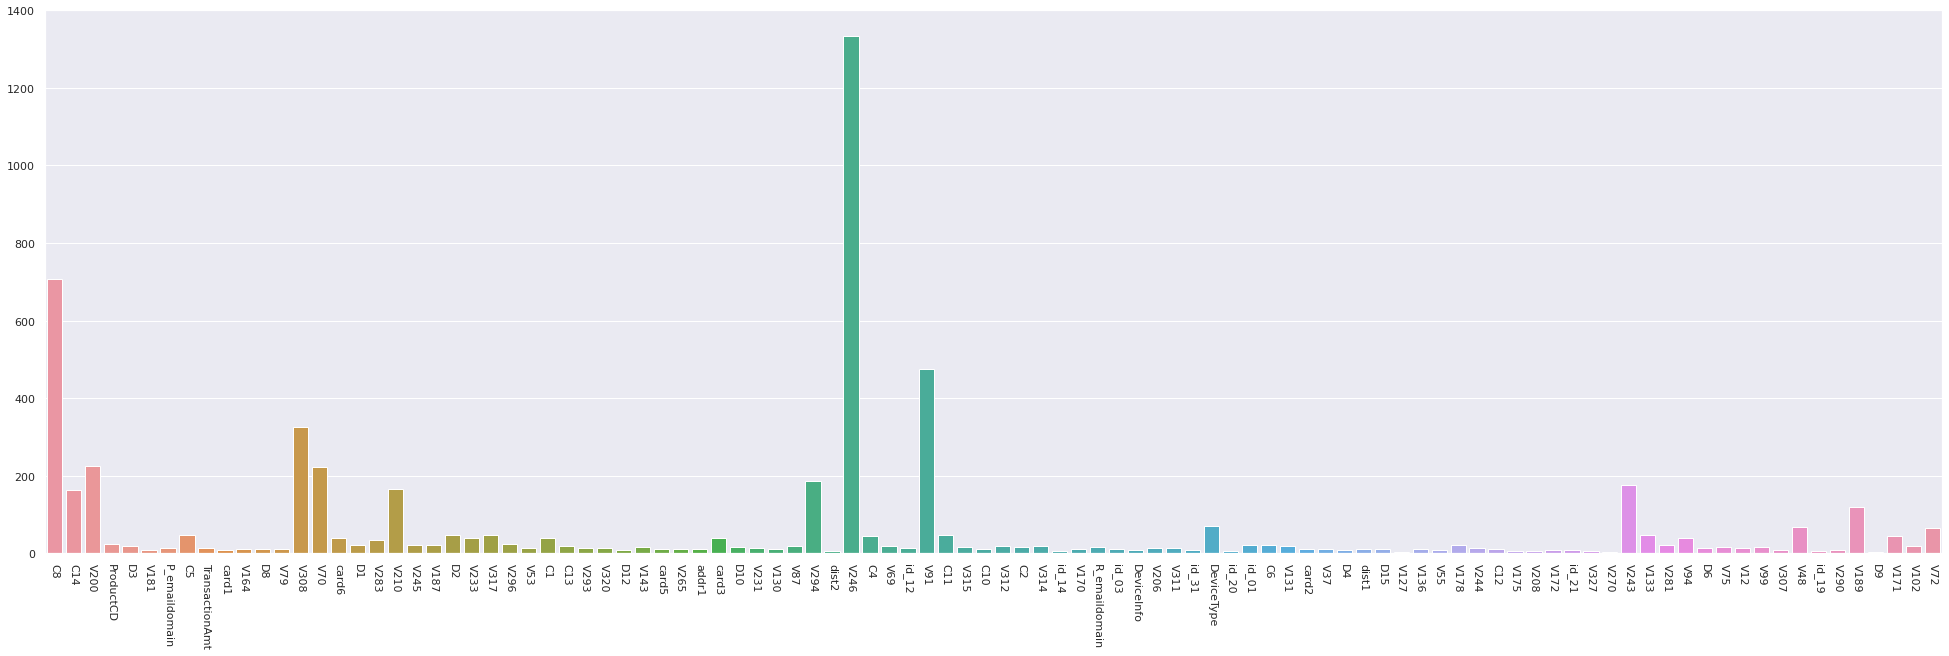

In [59]:
plt.figure(figsize=(34,10))
sns.barplot(x=list(scores.keys())[0:100], y=list(scores.values())[0:100])
plt.xticks(rotation=270)
plt.show()

In [62]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_full = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8875, recall: 0.7978, f1: 0.8403, aucPR: 0.9325, aucROC: 0.9392
precision: 0.8845, recall: 0.7968, f1: 0.8384, aucPR: 0.9292, aucROC: 0.9343
precision: 0.8842, recall: 0.8050, f1: 0.8427, aucPR: 0.9317, aucROC: 0.9396
precision: 0.8864, recall: 0.8156, f1: 0.8495, aucPR: 0.9354, aucROC: 0.9447
precision: 0.8759, recall: 0.8093, f1: 0.8413, aucPR: 0.9347, aucROC: 0.9425
precision: 0.8870, recall: 0.7904, f1: 0.8359, aucPR: 0.9261, aucROC: 0.9317
precision: 0.8787, recall: 0.7924, f1: 0.8333, aucPR: 0.9282, aucROC: 0.9350
precision: 0.8704, recall: 0.8093, f1: 0.8387, aucPR: 0.9275, aucROC: 0.9363
precision: 0.8791, recall: 0.7991, f1: 0.8372, aucPR: 0.9300, aucROC: 0.9402
precision: 0.8759, recall: 0.7996, f1: 0.8360, aucPR: 0.9303, aucROC: 0.9380
Final - precision: 0.8810, recall: 0.8015, f1: 0.8393, aucPR: 0.9306, aucROC: 0.9382


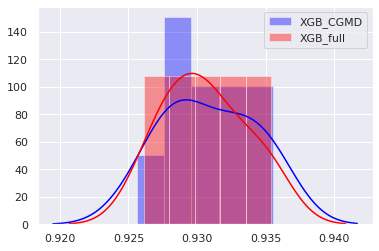

In [175]:
plt.figure()
sns.distplot(xgb_cgmd.aucs, color='blue', bins=5, label='XGB_CGMD')
sns.distplot(xgb_full.aucs, color='red', bins=5, label='XGB_full')
plt.legend()

In [176]:
ttest_rel(xgb_full.aucs, xgb_cgmdv.aucs)

Ttest_relResult(statistic=3.0554688976234465, pvalue=0.013671430319403027)